In [1]:
!lscpu |grep 'Model name'

Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 20 18:22:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
%cd /content/drive/MyDrive/faster_rcnn/

/content/drive/MyDrive/faster_rcnn


In [18]:
# copy the font file
!cp arial.ttf /usr/share/fonts/truetype

In [3]:
import sys
print(sys.path)
sys.path.append('/content/drive/MyDrive/TrainingStage2/')
# print(sys.path)

['/content', '/env/python', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.9/dist-packages/IPython/extensions', '/root/.ipython']


In [4]:
import os
import time
import json

import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms
from network_files import FasterRCNN, FastRCNNPredictor, AnchorsGenerator
from backbone import resnet50_fpn_backbone, MobileNetV2
from draw_box_utils import draw_objs

In [5]:

def create_model(num_classes):
    # Note: norm_layer should be the same as when you training
    backbone = resnet50_fpn_backbone(norm_layer=torchvision.ops.FrozenBatchNorm2d) # torchvision.ops.FrozenBatchNorm2d, torch.nn.BatchNorm2d
    model = FasterRCNN(backbone=backbone, num_classes=num_classes, rpn_score_thresh=0.5)

    return model


def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()

In [22]:

def main():
    # get devices
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    # create model
    model = create_model(num_classes=4) # num + 1

    # load train weights
    #weights_path = "./save_weights/model.pth"
    weights_path = "/content/drive/MyDrive/TrainingStage2/best_weights_SSMFVD/resNetFpn-model-10.pth" # best weights on SSMFVD
    assert os.path.exists(weights_path), "{} file dose not exist.".format(weights_path)
    model.load_state_dict(torch.load(weights_path, map_location='cpu')["model"])
    model.to(device)

    # read class_indict
    label_json_path = '/content/drive/MyDrive/TrainingStage2/masked_face_classes.json'
    assert os.path.exists(label_json_path), "json file {} dose not exist.".format(label_json_path)
    with open(label_json_path, 'r') as f:
        class_dict = json.load(f)

    category_index = {str(v): str(k) for k, v in class_dict.items()}

    # load image
    #original_img = Image.open("./test.jpg")
    input_path = "/content/drive/MyDrive/TrainingStage2/visualize_images/input/"
    input_image = "12_4_6.jpg"
    original_img = Image.open(input_path + input_image)

    # from pil image to tensor, do not normalize image
    data_transform = transforms.Compose([transforms.ToTensor()])
    img = data_transform(original_img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    model.eval()  # validation
    with torch.no_grad():
        # init
        img_height, img_width = img.shape[-2:]
        init_img = torch.zeros((1, 3, img_height, img_width), device=device)
        model(init_img)

        t_start = time_synchronized()
        predictions = model(img.to(device))[0]
        t_end = time_synchronized()
        print("inference+NMS time: {}".format(t_end - t_start))

        predict_boxes = predictions["boxes"].to("cpu").numpy()
        predict_classes = predictions["labels"].to("cpu").numpy()
        predict_scores = predictions["scores"].to("cpu").numpy()

        if len(predict_boxes) == 0:
            print("No object!")

        plot_img = draw_objs(original_img,
                             predict_boxes,
                             predict_classes,
                             predict_scores,
                             category_index=category_index,
                             box_thresh=0.5,
                             line_thickness=10,
                             font='arial.ttf',
                             font_size=36)
        plt.imshow(plot_img)
        plt.show()
        # save prediction results with bbox
        output_path = "/content/drive/MyDrive/TrainingStage2/visualize_images/output/"
        output_image = input_image.split('.')[0] + '_result.jpg'
        plot_img.save(output_path + output_image)

using cuda:0 device.
inference+NMS time: 0.12389183044433594


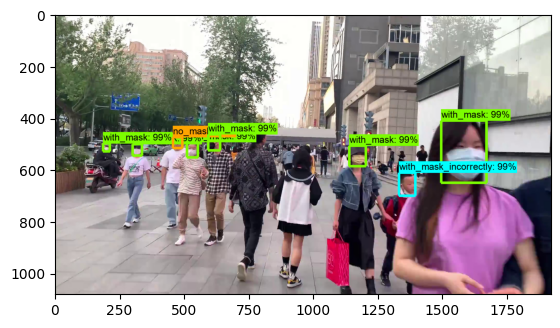

In [23]:
if __name__ == '__main__':
    main()

# Test the response time

In [ ]:
%cd /content/drive/MyDrive/dataset_images/

/content/drive/MyDrive/dataset_images


In [ ]:
!cp SSMFVD.zip /content

In [ ]:
%cd /content
!unzip SSMFVD.zip -d '/content/dataset'

In [ ]:
%cd /content/drive/MyDrive/TrainingStage2/data/own_video_dataset_txt/

/content/drive/MyDrive/faster_rcnn/data/own_video_dataset_txt


In [ ]:
!cp train.txt /content/dataset/ #
!cp valid.txt /content/dataset/ #
!cp test.txt /content/dataset/ #

In [ ]:
def test_respinse_time(path):
    # get devices
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    # create model
    model = create_model(num_classes=4) # num + 1

    # load train weights
    #weights_path = "./save_weights/model.pth"
    weights_path = "/content/drive/MyDrive/TrainingStage2/best_weights_SSMFVD/resNetFpn-model-10.pth" # best weights on SSMFVD
    assert os.path.exists(weights_path), "{} file dose not exist.".format(weights_path)
    model.load_state_dict(torch.load(weights_path, map_location='cpu')["model"])
    model.to(device)

    # read class_indict
    label_json_path = '/content/drive/MyDrive/TrainingStage2/masked_face_classes.json'
    assert os.path.exists(label_json_path), "json file {} dose not exist.".format(label_json_path)
    with open(label_json_path, 'r') as f:
        class_dict = json.load(f)

    category_index = {str(v): str(k) for k, v in class_dict.items()}

    # load image
    files= os.listdir(path)
    #original_img = Image.open("./test.jpg")
    response_time = []
    for i in files:
        if not i.endswith('.jpg'):
            continue
        original_img = Image.open(os.path.join(path, i))

        # from pil image to tensor, do not normalize image
        data_transform = transforms.Compose([transforms.ToTensor()])
        img = data_transform(original_img)
        # expand batch dimension
        img = torch.unsqueeze(img, dim=0)

        model.eval()  # validation
        with torch.no_grad():
            # init
            img_height, img_width = img.shape[-2:]
            init_img = torch.zeros((1, 3, img_height, img_width), device=device)
            model(init_img)

            t_start = time_synchronized()
            predictions = model(img.to(device))[0]
            t_end = time_synchronized()
            response_time.append(t_end - t_start)

    return response_time


    

In [ ]:
path = '/content/dataset/test'
response_time = test_respinse_time(path)

using cuda:0 device.


In [ ]:
len(response_time)

210

In [ ]:
import numpy as np
print(np.mean(np.array(response_time)))

0.11596348512740362
